In [1]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Read the CSV file without header
import io
df = pd.read_csv(io.BytesIO(uploaded['all_tickets_processed_improved_v3.csv']), sep=',')
columns = ['Document', 'Topic_group']
# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
print(df.head())




Saving all_tickets_processed_improved_v3.csv to all_tickets_processed_improved_v3.csv
Shape of the dataset: (47837, 2)
                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Preprocess Data
df['Document'] = df['Document'].str[:50]  # Truncate text to 50 characters
max_vocab_size = 20000
max_seq_length = 50

# Tokenize Text
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(df['Document'].values)
sequences = tokenizer.texts_to_sequences(df['Document'].values)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['Topic_group'].values)
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
one_hot_labels = np.eye(num_classes)[encoded_labels]

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, one_hot_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [5]:
# Create DataLoaders
def create_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.long)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test)

# Create Look-ahead Mask
def create_look_ahead_mask(size, device):
    mask = torch.ones((size, size), device=device)
    return torch.triu(mask, diagonal=1)



In [6]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, num_classes, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = self._generate_positional_encoding(max_seq_length, embedding_dim)
        self.encoder_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout),
            num_layers
        )
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def _generate_positional_encoding(self, seq_len, dim):
        pe = torch.zeros(seq_len, dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, mask=None):
        """
        Forward pass for the TransformerClassifier.

        Parameters:
        - x (torch.Tensor): Input tensor of shape (batch_size, seq_length).
        - mask (torch.Tensor): Optional look-ahead mask of shape (seq_length, seq_length).

        Returns:
        - output (torch.Tensor): Logits of shape (batch_size, num_classes).
        """
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        embedded += self.positional_encoding[:, :x.size(1), :]  # Add positional encoding
        transformer_out = self.encoder_layers(embedded.permute(1, 0, 2), mask)  # (seq_length, batch_size, embedding_dim)
        transformer_out = transformer_out.permute(1, 0, 2)  # Back to (batch_size, seq_length, embedding_dim)
        output = self.fc(self.dropout(transformer_out.mean(dim=1)))  # Mean pooling + classification head
        return output


In [7]:
# Initialize Transformer
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)
embedding_dim = 128
num_heads = 4
num_layers = 2
hidden_dim = 256
dropout_rate = 0.1

transformer_model = TransformerClassifier(
    vocab_size, embedding_dim, num_heads, num_layers, hidden_dim, num_classes, dropout_rate
).to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
# LSTM Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout=0.1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state
        output = self.fc(lstm_out)
        return output

# Initialize LSTM
hidden_dim = 64
lstm_model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    dropout=0.1
).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [9]:
# Training Function
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, device, use_mask=False):
    model.to(device)  # Ensure model is on the correct device
    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Move data to the correct device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            if use_mask:
                S = X_batch.size(1)
                mask = create_look_ahead_mask(S, device=device)  # Mask on the correct device
                predictions = model(X_batch, mask)
            else:
                predictions = model(X_batch)

            loss = criterion(predictions, torch.argmax(y_batch, dim=1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to the correct device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                if use_mask:
                    S = X_batch.size(1)
                    mask = create_look_ahead_mask(S, device=device)  # Mask on the correct device
                    predictions = model(X_batch, mask)
                else:
                    predictions = model(X_batch)

                loss = criterion(predictions, torch.argmax(y_batch, dim=1))
                total_val_loss += loss.item()
        val_losses.append(total_val_loss / len(val_loader))

    elapsed_time = time.time() - start_time
    return train_losses, val_losses, elapsed_time

# Optimizers and Criterion
optimizer_transformer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
# Train Models
epochs = 5
transformer_train_losses, transformer_val_losses, transformer_time = train_model(
    transformer_model, train_loader, val_loader, epochs, optimizer_transformer, criterion, device, use_mask=True
)

lstm_train_losses, lstm_val_losses, lstm_time = train_model(
    lstm_model, train_loader, val_loader, epochs, optimizer_lstm, criterion, device, use_mask=False
)


In [13]:
def evaluate_model(model, test_loader, device, use_mask=False):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            if use_mask:
                S = X_batch.size(1)
                mask = create_look_ahead_mask(S, device)
                predictions = model(X_batch, mask)
            else:
                predictions = model(X_batch)

            all_preds.append(predictions.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    predicted_classes = np.argmax(all_preds, axis=1)
    true_classes = np.argmax(all_targets, axis=1)

    mae = np.mean(np.abs(predicted_classes - true_classes))
    r2 = np.corrcoef(predicted_classes, true_classes)[0, 1] ** 2
    accuracy = (predicted_classes == true_classes).mean()

    return mae, r2, accuracy


In [16]:
# Evaluate Transformer Model
transformer_mae, transformer_r2, transformer_accuracy = evaluate_model(
    transformer_model, test_loader, device, use_mask=True
)

# Evaluate LSTM Model
lstm_mae, lstm_r2, lstm_accuracy = evaluate_model(
    lstm_model, test_loader, device, use_mask=False
)

# Print Evaluation Results
print("\nTransformer Evaluation Results:")
print(f"MAE: {transformer_mae:.4f}")
print(f"R²: {transformer_r2:.4f}")
print(f"Accuracy: {transformer_accuracy:.4f}")

print("\nLSTM Evaluation Results:")
print(f"MAE: {lstm_mae:.4f}")
print(f"Accuracy: {lstm_accuracy:.4f}")



Transformer Evaluation Results:
MAE: 0.5516
R²: 0.5923
Accuracy: 0.7690

LSTM Evaluation Results:
MAE: 1.4745
Accuracy: 0.2866


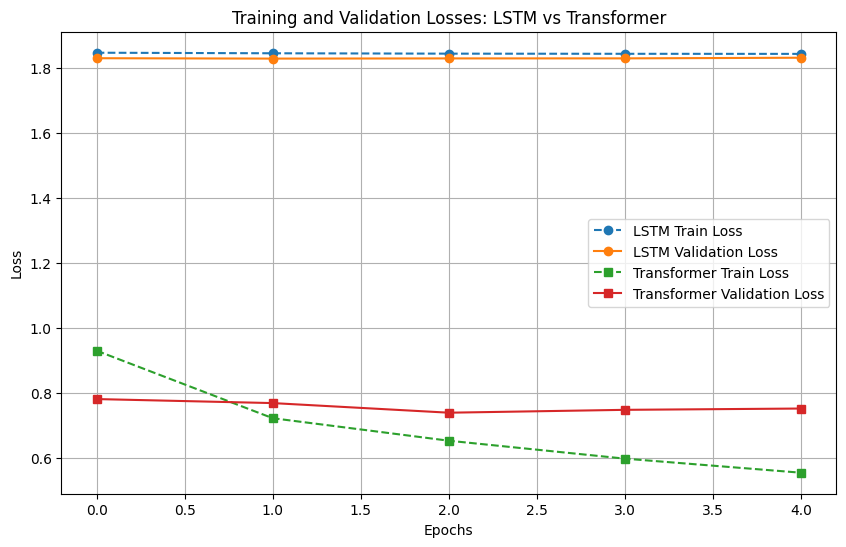

In [15]:
# Plot Training and Validation Losses
def plot_training_validation_losses(lstm_train, lstm_val, transformer_train, transformer_val, epochs):
    plt.figure(figsize=(10, 6))

    # Plot LSTM Losses
    plt.plot(range(epochs), lstm_train, label="LSTM Train Loss", linestyle="--", marker="o")
    plt.plot(range(epochs), lstm_val, label="LSTM Validation Loss", linestyle="-", marker="o")

    # Plot Transformer Losses
    plt.plot(range(epochs), transformer_train, label="Transformer Train Loss", linestyle="--", marker="s")
    plt.plot(range(epochs), transformer_val, label="Transformer Validation Loss", linestyle="-", marker="s")

    # Formatting
    plt.title("Training and Validation Losses: LSTM vs Transformer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_training_validation_losses(
    lstm_train_losses, lstm_val_losses,
    transformer_train_losses, transformer_val_losses,
    epochs
)


In [ ]:
from itertools import product

# Define the hyperparameter values for each setting
param_values = {
    'num_heads': [2, 4],
    'num_layers': [1, 2],
    'dropout_rate': [0.1, 0.2],
    'embedding_dim': [64, 128]
}

# Generate all combinations of the hyperparameters
param_combinations = list(product(*param_values.values()))

# Results storage
results = []

# Perform hyperparameter analysis
for params in param_combinations:
    num_heads, num_layers, dropout_rate, embedding_dim = params

    print(f"Testing Transformer with params: {params}")

    # Initialize Transformer model with current hyperparameters
    transformer_model = TransformerClassifier(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        hidden_dim=256,  # Fixed value
        num_classes=num_classes,
        dropout=dropout_rate
    ).to(device)

    # Define optimizer
    optimizer_transformer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

    # Train the Transformer
    epochs = 5
    transformer_train_losses, transformer_val_losses, transformer_time = train_model(
        transformer_model, train_loader, val_loader, epochs, optimizer_transformer, criterion, device, use_mask=True
    )

    # Evaluate the Transformer
    transformer_mae, transformer_r2, transformer_accuracy = evaluate_model(
        transformer_model, test_loader, device, use_mask=True
    )

    # Store results
    results.append({
        'params': {
            'num_heads': num_heads,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate,
            'embedding_dim': embedding_dim
        },
        'mae': transformer_mae,
        'r2': transformer_r2,
        'accuracy': transformer_accuracy,
        'training_time': transformer_time
    })

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Save to CSV for further analysis
results_df.to_csv("transformer_hyperparameter_analysis.csv", index=False)


Testing Transformer with params: (2, 1, 0.1, 64)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Testing Transformer with params: (2, 1, 0.1, 128)
Testing Transformer with params: (2, 1, 0.2, 64)
Testing Transformer with params: (2, 1, 0.2, 128)
Testing Transformer with params: (2, 2, 0.1, 64)
Testing Transformer with params: (2, 2, 0.1, 128)
Testing Transformer with params: (2, 2, 0.2, 64)
Testing Transformer with params: (2, 2, 0.2, 128)
Testing Transformer with params: (4, 1, 0.1, 64)
Testing Transformer with params: (4, 1, 0.1, 128)
Testing Transformer with params: (4, 1, 0.2, 64)
Testing Transformer with params: (4, 1, 0.2, 128)
